# Интеллектуальный анализ данных – весна 2022

# Домашнее задание 7: Деревья. Случайный лес

Правила:

- Домашнее задание оценивается в 10 баллов (+1 бонусный балл).


- Можно использовать без доказательства любые результаты, встречавшиеся на лекциях или семинарах по курсу, если получение этих результатов не является вопросом задания.


- Можно использовать любые свободные источники с обязательным указанием ссылки на них.


- Плагиат не допускается. При обнаружении случаев списывания, 0 за работу выставляется всем участникам нарушения, даже если можно установить, кто у кого списал.

## Часть 1: Основы построения решающие дерева (1.5 балла)

В этой части все расчёты необходимо реализовывать в виде запрограммированных формул, например, на `numpy`. **Нельзя использовать готовые реализации**. Например, если в задании требуется рассчитать энтропию, то требуется в каком-то виде релизовать расчёт по формуле, но нельзя использовать готовую реализацию `some_module.entropy()`.

In [74]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

**Задание 1.1 (0.5 балла)** Пусть известно, что в вершину решающего дерева попали 10 объектов, 8 из которых имеют метку класса $k_1$, а 2 имеют метку класса $k_2$. Рассчитайте энтропию такого распределения классов (с натуральным логарифмом). Ответ округлите до двух знаков после запятой.

In [75]:
n_numbers = 10
x = np.arange(0, n_numbers)

# labels
k1 = int(True)
k2 = int(False)

print(x)
print(bool_x := x < 8)

p = np.bincount(bool_x) / n_numbers
print(f"{p = }\n")

entropy = -np.sum(p * np.log(p)).round(2)
entropy

[0 1 2 3 4 5 6 7 8 9]
[ True  True  True  True  True  True  True  True False False]
p = array([0.2, 0.8])



0.5

**Задание 1.2 (0.5 балла)** Пусть дополнительно известно, что вершина из предыдущего задания не является листовой и возможно такое разбиение, что в левое поддерево попадут все объекты класса $k_1$, а в правое - класса $k_2$. Посчитайте критерий информативности:

$$
Q(R_m, j, t) = H(R_m) - \frac{|R_\ell|}{|R_m|}H(R_\ell) - \frac{|R_r|}{|R_m|}H(R_r),
$$

где $R_m$ - множество объектов в разбиваемой вершине, $j$ - номер признака, по которому происходит разбиение, $t$ - порог разбиения, $R_\ell$ - множество объектов в левом поддереве, $R_r$ - множество объектов в правом поддереве.

Теперь в качестве $H(R)$ будем использовать индекс Джини:

$$
H(R) = \sum_{k=1}^J p_k(1-p_k),
$$
где $J$ – общее количество классов (в нашем случае, $J = 2$).

Ответ округлите до двух знаков после запятой.

In [79]:
# Use vars from prefious task

def gini(p:np.ndarray):
    return np.sum(p * (1 - p))


def Q(Rm: np.ndarray, t, j = None):
    Rl = Rm[Rm < t]
    Rr = Rm[Rm >= t]
    
    p = np.bincount(Rm < t) / Rm.size
    p_l = np.bincount(Rl < t, minlength=p.size) / Rl.size
    p_r = np.bincount(Rr < t, minlength=p.size) / Rr.size
    
    return gini(p) - p_l.size / p.size * gini(p_l) - p_r.size / p.size * gini(p_r)

# labels
k1 = int(True)  # 8
k2 = int(False) # 2

n_numbers = 10
x = np.arange(0, n_numbers)

print("Q =", Q(x, 8))

Q = 0.32


**Задание 1.3 (0.5 балла)** Пусть при построении дерева образовалась листовая вершина с 10 объектами, значения целевой переменной для которых следующие: [1, 10, 5, 18, 100, 30, 50, 61, 84, 47] (решается задача регрессии). Чему будут равны предсказания модели для этих объектов?

In [103]:
# Т.к. решается задача регрессии, прогноз будет равен среднему значению
x = [1, 10, 5, 18, 100, 30, 50, 61, 84, 47]
np.mean(x)

40.6

## Часть 2: Решающие деревья (4.5 балла)

В этой части мы напишем и протестируем собственную реализацию решающего дерева.

In [3]:
from collections import Counter
from typing import Dict, List, Tuple, Union

**Задание 2.1 (1.5 балла)** Реализуйте функцию `find_best_split()`, которая должна находить оптимальное разбиение подмножества обучающей выборки в соответствии с информационным критерием из **Задания 1.2**. В качестве меры хаотичности $H(R)$ для задачи регрессии испольуйте дисперсию подвыборки, а для задачи классификации – критерий Джини (определён в том же задании).

Для категориальных признаков применяется наивный алгоритм разбиения: мы пытаемся найти одно значение, разбиение по которому сильнее всего увеличит критерий информативности. Иными словами, объекты с конкретным значением признака отправляем в левое поддерево, остальные - в правое. Обратите внимание, что это далеко не оптимальные способ учёта категориальных признаков. Например, можно было бы на каждое значение категориального признака создавать отдельное поддерево или использовать более сложные подходы. Подробнее об этом можно прочитать в конспектах [лекций](https://github.com/esokolov/ml-course-hse/blob/master/2019-fall/lecture-notes/lecture07-trees.pdf) по машинному обучению на ПМИ (раздел «Учёт категориальных признаков»).

В качестве подсказок реализации можете пользоваться кодом из бонусной части семинара по решающим деревьям.

**Бонус:** Разрешается делать цикл для перебора порогов, но возможна имплементация без него. За имплементацию без цикла – **бонус 1 балл**.

In [48]:
x = np.array([[8, 3],
    [6, 2],
    [4, 1],
    [6, 3],
    [8, 1],
    [6, 1]])

In [49]:
H(x, 'classification')

[0.         0.5        0.16666667 0.33333333]


0.6111111111111112

In [174]:
from typing import Iterable, List, Tuple

def H(R: np.array, task: str = 'regression'):

    def gini(p:np.ndarray):
        return np.sum(p * (1 - p))
    # print(f"{R = }")
    
    if task == 'regression':
        return np.var(R)
    elif task == 'classification':
        return gini(R)
    

def Q_err(Rm: np.ndarray, j, t, task, typ):
    
    if typ == 'real':
        Rl = Rm[Rm < t]
        Rr = Rm[Rm >= t]        
    
    if task == 'classification':
        
        Rl = Rm[Rm == t]
        Rr = Rm[Rm != t]
        
        p = np.bincount(Rm[-1]) / Rm.size
        p_l = np.bincount(Rl < t, minlength=p.size) / Rl.size
        p_r = np.bincount(Rr < t, minlength=p.size) / Rr.size
        return H(p, task) - p_l.size / p.size * H(p_l, task) - p_r.size / p.size * H(p_r, task)
    
    return H(Rm) - Rl.size / Rm.size * H(Rl) - Rr.size / Rm.size * H(Rr)
   

In [177]:
def find_best_split(
    feature_vector: Union[np.ndarray, pd.DataFrame], 
    target_vector: Union[np.ndarray, pd.Series],
    task: str = "classification",
    feature_type: str = "real"
) -> Tuple[np.ndarray, np.ndarray, float, float]:
    """
    Указания:
    * Пороги, приводящие к попаданию в одно из поддеревьев пустого множества объектов, не рассматриваются.
    * В качестве порогов, нужно брать среднее двух сосдених (при сортировке) значений признака
    * Поведение функции в случае константного признака может быть любым.
    * При одинаковых приростах Джини или дисперсии нужно выбирать минимальный сплит.
    * За наличие в функции циклов балл будет снижен. Векторизуйте! :)

    :param feature_vector: вещественнозначный вектор значений признака
    :param target_vector: вектор классов объектов,  len(feature_vector) == len(target_vector)
    :param task: либо `classification`, либо `regression`
    :param feature_type: либо `real`, либо `categorical`
    
    :return thresholds: отсортированный по возрастанию вектор со всеми возможными порогами, по которым объекты можно
     разделить на две различные подвыборки, или поддерева
    :return ginis: вектор со значениями критерия Джини для каждого из порогов в thresholds len(ginis) == len(thresholds)
    :return threshold_best: оптимальный порог (число)
    :return gini_best: оптимальное значение критерия Джини (число)
    """
     
    if feature_type == 'real':
        s_feature_vector = np.sort(feature_vector)
        thresholds = (s_feature_vector[:-1] + s_feature_vector[1:]) / 2
    else:
        thresholds = pd.unique(feature_vector)
    
    qs = []
    
    # gini считаем несколько раз, а разбиение происходит по критерию информативности.
    for t in thresholds:
        q = Q_err(feature_vector, 0, t, task, feature_type)
        qs.append(q)
        # print(q)
    
    q_best = np.max(qs)
    threshold_best = thresholds[np.argmax(qs)]
    
    return thresholds, qs, threshold_best, q_best
    
thresholds, variances, threshold_best, variance_best = find_best_split(
    X["CRIM"].to_numpy(), 
    y, 
    task="regression",
    feature_type="real"
)

Эту функцию можно протестировать на датасете `Boston` из `sklearn`.

In [178]:
from sklearn.datasets import load_boston

boston = load_boston()
X = pd.DataFrame(data=boston["data"], columns=boston["feature_names"])
y = boston["target"]
X.head()

print(boston["DESCR"])

.. _boston_dataset:

Boston house prices dataset
---------------------------

**Data Set Characteristics:**  

    :Number of Instances: 506 

    :Number of Attributes: 13 numeric/categorical predictive. Median Value (attribute 14) is usually the target.

    :Attribute Information (in order):
        - CRIM     per capita crime rate by town
        - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
        - INDUS    proportion of non-retail business acres per town
        - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
        - NOX      nitric oxides concentration (parts per 10 million)
        - RM       average number of rooms per dwelling
        - AGE      proportion of owner-occupied units built prior to 1940
        - DIS      weighted distances to five Boston employment centres
        - RAD      index of accessibility to radial highways
        - TAX      full-value property-tax rate per $10,000
        - PTRATIO  pu

Выведите график зависимости значения критерия ошибки от порогового значения при разбиении вершины по признаку `CRIM`.

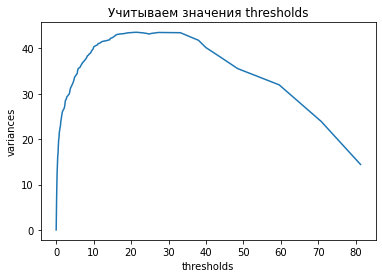

In [179]:
sns.lineplot(x=thresholds, y=variances)
plt.xlabel('thresholds')
plt.ylabel('variances')
plt.title("Учитываем значения thresholds")
plt.show()

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


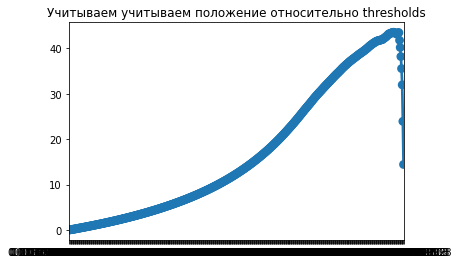

In [180]:
k = np.sort(X['CRIM'].to_numpy())
sns.pointplot(thresholds, variances)
plt.title("Учитываем учитываем положение относительно thresholds")
plt.show()

**Задание 2.2 (1 балл)** Разберитесь с написанным кодом решающего дерева, заполните пропуски в коде и реализуйте недостающий метод `_predict_node()`.

Построение дерева осуществляется согласно базовому жадному алгоритму, предложенному в лекции в разделе «Построение дерева».
- **Выбор лучшего разбиения** необходимо производить по критерию Джини.
- **Критерий останова:** все объекты в листе относятся к одному классу или ни по одному признаку нельзя разбить выборку.
- **Ответ в листе:** наиболее часто встречающийся класс в листе.

In [368]:
class DecisionTree:
    
    def __init__(
        self, 
        feature_types: Union[List[str], np.ndarray], 
        max_depth: int = None, 
        min_samples_split: int = None, 
        min_samples_leaf: int = None,
        task: str = "classification"
    ) -> None:
        
        if np.any(list(map(lambda x: x != "real" and x != "categorical", feature_types))):
            raise ValueError("There is unknown feature type")

        print(f"{feature_types = }")    
        print(f"{max_depth = }") 
        print(f"{min_samples_split = }") 
        print(f"{min_samples_leaf = }") 
        print(f"{task = }") 
        
        # В этой переменной будем хранить узлы решающего дерева. Каждая вершина хранит в себе идентификатор того,
        # является ли она листовой. Листовые вершины хранят значение класса для предсказания, нелистовые - правого и
        # левого детей (поддеревья для продолжения процедуры предсказания)
        self._tree = {}
        
        # типы признаков (категориальные или числовые)
        self._feature_types = feature_types
        
        # гиперпараметры дерева
        self._max_depth = max_depth
        self._min_samples_split = min_samples_split
        self._min_samples_leaf = min_samples_leaf
        self.task = task

    def _fit_node(
        self, 
        sub_X: np.ndarray, 
        sub_y: np.ndarray, 
        node: dict
    ) -> None:
        
        
        print("sub_X:", sub_X.shape)
#        критерий останова
        if np.all(sub_y == sub_y[0]):
            node["type"] = "terminal"
            node["class"] = sub_y[0]
            return

        feature_best, threshold_best, gini_best, split = None, None, None, None
        for feature in range(sub_X.shape[1]):
            # print("\n feature =", feature)
            feature_type = self._feature_types[feature]
            categories_map = {}

            # подготавливаем признак для поиска оптимального порога
            if feature_type == "real":
                feature_vector = sub_X[:, feature]
            elif feature_type == "categorical":
                # здесь могла быть реализация более сложного подхода к обработке категориального признака
                feature_vector = sub_X[:, feature]

            # ищем оптимальный порог
            _, _, threshold, gini = find_best_split(feature_vector, sub_y, self.task, feature_type)
            print(f"{threshold = }, {gini = }")
            
            if gini_best is None or gini > gini_best:
                feature_best = feature
                gini_best = gini

                # split - маска на объекты, которые должны попасть в левое поддерево
                if feature_type == "real":
                    threshold_best = threshold
                    split = (sub_X < threshold)[:, feature]
                elif feature_type == "categorical":
                    # в данной реализации это просто значение категории
                    threshold_best = threshold
                    split = (sub_X == threshold)[:, feature]
                else:
                    raise ValueError

        # print(split)
        print(split.shape, '\n\n')
        # записываем полученные сплиты в атрибуты класса
        if feature_best is None:
            node["type"] = "terminal"
            node["class"] = Counter(sub_y).most_common(1)[0][0]
            return

        node["type"] = "nonterminal"

        node["feature_split"] = feature_best
        if self._feature_types[feature_best] == "real":
            node["threshold"] = threshold_best
        elif self._feature_types[feature_best] == "categorical":
            node["category_split"] = threshold_best
        else:
            raise ValueError
            
        node["left_child"], node["right_child"] = {}, {}
        self._fit_node(sub_X[split], sub_y[split], node["left_child"])
        self._fit_node(sub_X[np.logical_not(split)], sub_y[np.logical_not(split)], node["right_child"])

    def _predict_node(self, x: np.ndarray, node: dict) -> int:
        """
        Предсказание начинается с корневой вершины дерева и рекурсивно идёт в левое или правое поддерево в зависимости от значения
        предиката на объекте. Листовая вершина возвращает предсказание.
        :param x: np.array, элемент выборки
        :param node: dict, вершина дерева
        """
        if node['type'] == 'terminal':
            return node['class']
        
        if self._feature_types[feature_best] == "real":
            if x[node['feature_split']] < node['threshold']:
                return self._predict_node(x, node['left_child'])
            else:
                return self._predict_node(x, node['right_child'])
        elif self._feature_types[feature_best] == "categorical":
            if x[node['feature_split']] == node['threshold']:
                return self._predict_node(x, node['left_child'])
            else:
                return self._predict_node(x, node['right_child'])
        else:
            raise ValueError
        
        

    def fit(self, X: np.ndarray, y: np.ndarray) -> None:
        self._fit_node(X, y, self._tree)

    def predict(self, X: np.ndarray) -> np.ndarray:
        predicted = []
        for x in X:
            predicted.append(self._predict_node(x, self._tree))
            
        return np.array(predicted)

**Задание 2.3 (1 балл)** Загрузите таблицу `students.csv` (это немного преобразованный датасет [User Knowledge](https://archive.ics.uci.edu/ml/datasets/User+Knowledge+Modeling)). В ней признаки объекта записаны в первых пяти столбцах, а в последнем записана целевая переменная (класс: 0 или 1). Постройте на одном изображении пять кривых "порог — значение критерия Джини" для всех пяти признаков. Отдельно визуализируйте диаграммы рассеяния "значение признака — класс" для всех пяти признаков.

In [194]:
data = pd.read_csv('students.csv')
print(f"Dataset shape: {data.shape}")

Dataset shape: (258, 7)


,Unnamed: 0,STG,SCG,STR,LPR,PEG,UNS
0,0,0.00,0.00,0.00,0.00,0.00,0
1,1,0.08,0.08,0.10,0.24,0.90,1
2,2,0.06,0.06,0.05,0.25,0.33,0
3,3,0.10,0.10,0.15,0.65,0.30,1
4,4,0.08,0.08,0.08,0.98,0.24,0


In [195]:
data = data.drop(columns=['Unnamed: 0'])
data

,STG,SCG,STR,LPR,PEG,UNS
0,0.00,0.00,0.00,0.00,0.00,0
1,0.08,0.08,0.10,0.24,0.90,1
2,0.06,0.06,0.05,0.25,0.33,0
3,0.10,0.10,0.15,0.65,0.30,1
4,0.08,0.08,0.08,0.98,0.24,0
...,...,...,...,...,...,...
253,0.61,0.78,0.69,0.92,0.58,1
254,0.78,0.61,0.71,0.19,0.60,1
255,0.54,0.82,0.71,0.29,0.77,1
256,0.50,0.75,0.81,0.61,0.26,1


In [198]:
data.columns

Index(['STG', 'SCG', 'STR', 'LPR', 'PEG', 'UNS'], dtype='object')

In [221]:
y = data['UNS']
X = data.drop(columns=['UNS'])
X

,STG,SCG,STR,LPR,PEG
0,0.00,0.00,0.00,0.00,0.00
1,0.08,0.08,0.10,0.24,0.90
2,0.06,0.06,0.05,0.25,0.33
3,0.10,0.10,0.15,0.65,0.30
4,0.08,0.08,0.08,0.98,0.24
...,...,...,...,...,...
253,0.61,0.78,0.69,0.92,0.58
254,0.78,0.61,0.71,0.19,0.60
255,0.54,0.82,0.71,0.29,0.77
256,0.50,0.75,0.81,0.61,0.26


C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3702: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_methods.py:221: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_methods.py:253: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3702: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_methods.py:221: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
C:\ProgramData\Anaconda3\lib\site-packages

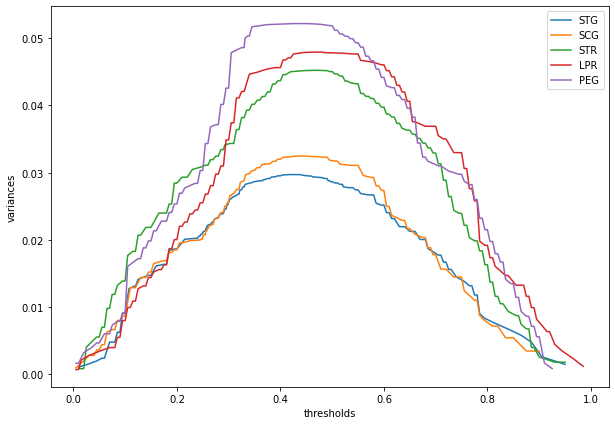

In [209]:
plt.figure(figsize=(10, 7))
for c in X.columns:
    thresholds, variances, _, _ = find_best_split(
        X[c].to_numpy(), 
        y, 
        task="regression",
        feature_type="real")
    plt.plot(thresholds, variances, label=c)
plt.legend()
plt.xlabel('thresholds')
plt.ylabel('variances')
plt.show()

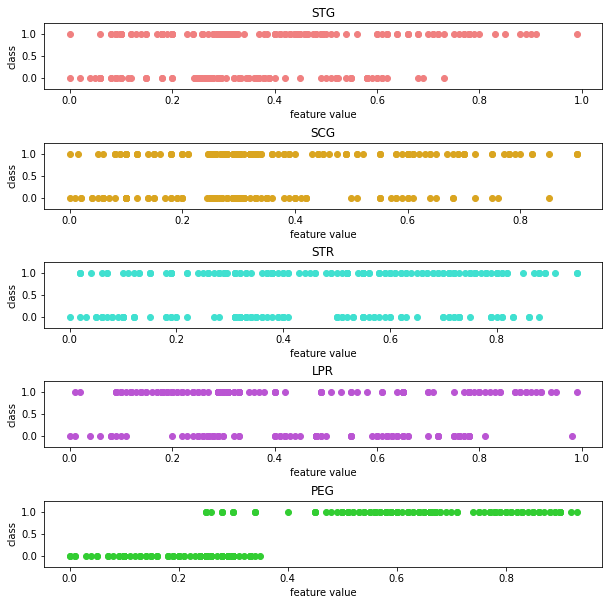

In [262]:
# Цветом не получилось, непонятно, какой брать параметр y= .

fig, ax = plt.subplots(nrows=5, ncols=1, figsize=(10, 10))
colors = ['lightcoral', 'goldenrod', 'turquoise', 'mediumorchid', 'limegreen']
for i in range(len(X.columns)):
    ax_i = ax[i]
    ax_i.scatter(x=X[X.columns[i]], y=y, c=colors[i])
    ax_i.set_title(X.columns[i])
    ax_i.set_ylim(-0.25, 1.25)
    ax_i.set_xlabel('feature value')
    ax_i.set_ylabel('class')

plt.subplots_adjust(hspace=0.8)
plt.show()


Исходя из кривых значений критерия Джини, по какому признаку нужно производить деление выборки на два поддерева? Согласуется ли этот результат с визуальной оценкой диаграмм рассеяиния? Как бы охарактеризовали вид кривой для "хороших" признаков, по которым выборка делится почти идеально? Чем отличаются кривые для признаков, по которым деление практически невозможно?

> Проанализировав графики, можно заметить, что наибольльшее изменение критерия хаотичности происходит при отборе по признаку `PEG`. Это заметно из диаграммы зависимости от порога, где этот признак соответствует верхней линии. Аналогично, на последней диаграмме разброса, очевидно, что разделяя по `PEG` мы получаем более корректное разделение с меньшим количеством так называемых выбросов.

**Задание 2.4 (1 балл)** Протестируйте свое решающее дерево на датасете [mushrooms](https://archive.ics.uci.edu/ml/datasets/Mushroom). 

1. Скачайте таблицу `agaricus-lepiota.data` (из [Data Folder](https://archive.ics.uci.edu/ml/machine-learning-databases/mushroom/)), 
2. Считайте таблицу при помощи `pandas`,
3. Примените к каждому столбцу `LabelEncoder` (из `sklearn`), чтобы преобразовать строковые имена категорий в натуральные числа. 

Первый столбец — это целевая переменная (e — edible, p — poisonous) Мы будем измерять качество с помощью accuracy, так что нам не очень важно, что будет классом 1, а что — классом 0. Обучите решающее дерево на половине случайно выбранных объектов (признаки в датасете категориальные) и сделайте предсказания для оставшейся половины. Вычислите accuracy.

In [335]:
mushs = pd.read_csv('agaricus-lepiota.data')
print(f"Dataset shape: {mushs.shape}")

Dataset shape: (8123, 23)


In [336]:
mushs

,p,x,s,n,t,p.1,f,c,n.1,k,...,s.2,w,w.1,p.2,w.2,o,p.3,k.1,s.3,u
0,e,x,s,y,t,a,f,c,b,k,...,s,w,w,p,w,o,p,n,n,g
1,e,b,s,w,t,l,f,c,b,n,...,s,w,w,p,w,o,p,n,n,m
2,p,x,y,w,t,p,f,c,n,n,...,s,w,w,p,w,o,p,k,s,u
3,e,x,s,g,f,n,f,w,b,k,...,s,w,w,p,w,o,e,n,a,g
4,e,x,y,y,t,a,f,c,b,n,...,s,w,w,p,w,o,p,k,n,g
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8118,e,k,s,n,f,n,a,c,b,y,...,s,o,o,p,o,o,p,b,c,l
8119,e,x,s,n,f,n,a,c,b,y,...,s,o,o,p,n,o,p,b,v,l
8120,e,f,s,n,f,n,a,c,b,n,...,s,o,o,p,o,o,p,b,c,l
8121,p,k,y,n,f,y,f,c,n,b,...,k,w,w,p,w,o,e,w,v,l


In [337]:
y = mushs['p']
X = mushs.drop(columns=['p'])

In [338]:
X.head()

,x,s,n,t,p.1,f,c,n.1,k,e,...,s.2,w,w.1,p.2,w.2,o,p.3,k.1,s.3,u
0,x,s,y,t,a,f,c,b,k,e,...,s,w,w,p,w,o,p,n,n,g
1,b,s,w,t,l,f,c,b,n,e,...,s,w,w,p,w,o,p,n,n,m
2,x,y,w,t,p,f,c,n,n,e,...,s,w,w,p,w,o,p,k,s,u
3,x,s,g,f,n,f,w,b,k,t,...,s,w,w,p,w,o,e,n,a,g
4,x,y,y,t,a,f,c,b,n,e,...,s,w,w,p,w,o,p,k,n,g


In [340]:
_X = X.to_numpy()
X = _X
y = y.to_numpy()

---

In [369]:
dt = DecisionTree(['categorical'] * 22)

feature_types = ['categorical', 'categorical', 'categorical', 'categorical', 'categorical', 'categorical', 'categorical', 'categorical', 'categorical', 'categorical', 'categorical', 'categorical', 'categorical', 'categorical', 'categorical', 'categorical', 'categorical', 'categorical', 'categorical', 'categorical', 'categorical', 'categorical']
max_depth = None
min_samples_split = None
min_samples_leaf = None
task = 'classification'


In [371]:
dt.fit(X, y)

sub_X: (8123, 22)
threshold = 'x', gini = 0.494991378781082
threshold = 'y', gini = 0.47974311736565267
threshold = 'y', gini = 0.22910923184621937
threshold = 't', gini = 0.48571506816537907
threshold = 'y', gini = 0.13176313599799122
threshold = 'f', gini = 0.05036832975896002
threshold = 'w', gini = 0.27085808555699137
threshold = 'n', gini = 0.4271313656556057
threshold = 'w', gini = 0.24229723971375636
threshold = 't', gini = 0.49094731472949693
threshold = 'e', gini = 0.21736849738577196
threshold = 's', gini = 0.4446310246024288
threshold = 's', gini = 0.29709324055454855
threshold = 'w', gini = 0.4905551486725442
threshold = 'w', gini = 0.4836299288685699
threshold = 'p', gini = nan
threshold = 'y', gini = 0.0019677757324906738
threshold = 't', gini = 0.1368167914558887
threshold = 'p', gini = 0.4997293171713636
threshold = 'w', gini = 0.40331212069658673
threshold = 'y', gini = 0.33267994914275734
threshold = 'p', gini = 0.18403194875520235
(8123,) 


sub_X: (3967, 22)
thresho

<ipython-input-174-7dc6c4b5a9d5>:34: RuntimeWarning: invalid value encountered in true_divide
  p_r = np.bincount(Rr < t, minlength=p.size) / Rr.size


threshold = 'w', gini = 0.048675893993638066
threshold = 't', gini = 0.11336723879771624
threshold = 'p', gini = nan
threshold = 'n', gini = 0.24657008960128035
threshold = 'y', gini = 0.38876895689452123
threshold = 'u', gini = 0.15860336961580385
(1923,) 


sub_X: (1923, 22)
threshold = 'x', gini = nan
threshold = 'y', gini = 0.47101499244577166
threshold = 'w', gini = 0.1944881029128589
threshold = 't', gini = 0.31205142121441487
threshold = 'n', gini = 0.22148861130660352
threshold = 'f', gini = 0.048675893993638066
threshold = 'w', gini = 0.2184574122434476
threshold = 'n', gini = 0.32887381017861617
threshold = 'w', gini = 0.3508840455310209
threshold = 't', gini = 0.49517013441848123
threshold = 'c', gini = 0.13109619001263917
threshold = 's', gini = 0.0545818855811013
threshold = 'y', gini = 0.09859572750044683
threshold = 'w', gini = 0.4398461949918454
threshold = 'w', gini = 0.4398461949918454
threshold = 'p', gini = nan
threshold = 'w', gini = 0.048675893993638066
threshold 

threshold = 't', gini = 0.31205142121441487
threshold = 'n', gini = 0.22148861130660352
threshold = 'f', gini = 0.048675893993638066
threshold = 'w', gini = 0.2184574122434476
threshold = 'n', gini = 0.32887381017861617
threshold = 'w', gini = 0.3508840455310209
threshold = 't', gini = 0.49517013441848123
threshold = 'c', gini = 0.13109619001263917
threshold = 's', gini = 0.0545818855811013
threshold = 'y', gini = 0.09859572750044683
threshold = 'w', gini = 0.4398461949918454
threshold = 'w', gini = 0.4398461949918454
threshold = 'p', gini = nan
threshold = 'w', gini = 0.048675893993638066
threshold = 't', gini = 0.11336723879771624
threshold = 'p', gini = nan
threshold = 'n', gini = 0.24657008960128035
threshold = 'y', gini = 0.38876895689452123
threshold = 'u', gini = 0.15860336961580385
(1923,) 


sub_X: (1923, 22)
threshold = 'x', gini = nan
threshold = 'y', gini = 0.47101499244577166
threshold = 'w', gini = 0.1944881029128589
threshold = 't', gini = 0.31205142121441487
threshold =

threshold = 'y', gini = 0.38876895689452123
threshold = 'u', gini = 0.15860336961580385
(1923,) 


sub_X: (1923, 22)
threshold = 'x', gini = nan
threshold = 'y', gini = 0.47101499244577166
threshold = 'w', gini = 0.1944881029128589
threshold = 't', gini = 0.31205142121441487
threshold = 'n', gini = 0.22148861130660352
threshold = 'f', gini = 0.048675893993638066
threshold = 'w', gini = 0.2184574122434476
threshold = 'n', gini = 0.32887381017861617
threshold = 'w', gini = 0.3508840455310209
threshold = 't', gini = 0.49517013441848123
threshold = 'c', gini = 0.13109619001263917
threshold = 's', gini = 0.0545818855811013
threshold = 'y', gini = 0.09859572750044683
threshold = 'w', gini = 0.4398461949918454
threshold = 'w', gini = 0.4398461949918454
threshold = 'p', gini = nan
threshold = 'w', gini = 0.048675893993638066
threshold = 't', gini = 0.11336723879771624
threshold = 'p', gini = nan
threshold = 'n', gini = 0.24657008960128035
threshold = 'y', gini = 0.38876895689452123
threshold =

threshold = 'c', gini = 0.13109619001263917
threshold = 's', gini = 0.0545818855811013
threshold = 'y', gini = 0.09859572750044683
threshold = 'w', gini = 0.4398461949918454
threshold = 'w', gini = 0.4398461949918454
threshold = 'p', gini = nan
threshold = 'w', gini = 0.048675893993638066
threshold = 't', gini = 0.11336723879771624
threshold = 'p', gini = nan
threshold = 'n', gini = 0.24657008960128035
threshold = 'y', gini = 0.38876895689452123
threshold = 'u', gini = 0.15860336961580385
(1923,) 


sub_X: (1923, 22)
threshold = 'x', gini = nan
threshold = 'y', gini = 0.47101499244577166
threshold = 'w', gini = 0.1944881029128589
threshold = 't', gini = 0.31205142121441487
threshold = 'n', gini = 0.22148861130660352
threshold = 'f', gini = 0.048675893993638066
threshold = 'w', gini = 0.2184574122434476
threshold = 'n', gini = 0.32887381017861617
threshold = 'w', gini = 0.3508840455310209
threshold = 't', gini = 0.49517013441848123
threshold = 'c', gini = 0.13109619001263917
threshold =

KeyboardInterrupt: 

## Часть 3: Бэггинг и случайный лес (4 балла)

В данной части мы будем работать [с задачей предсказания диабета у пациента](https://www.kaggle.com/uciml/pima-indians-diabetes-database/data). Посмотрим на работу бэггинга над решающими деревьями и случайного леса, сравним их работу.

In [5]:
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
import seaborn as sns

In [6]:
data = pd.read_csv('diabetes.csv')
print(f"Dataset shape: {data.shape}")
data.head()

Dataset shape: (768, 9)


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


Посмотрим на распределение целевой переменной

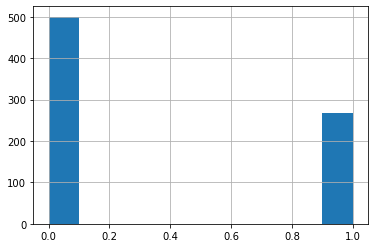

In [7]:
data['Outcome'].hist()
plt.show()

**Задание 3.1 (0.5 балла)** Разделите данные на признаки и целевую переменную. Разбейте датасет на обучающую и тестовую части в отношении 7:3. Затем разделите обучающую выборку на обучающую-обучающую и обучающую-валидационную в соотношении 7:3 (то есть в итоге должно получиться три выборки: обучающая-обучающая (0.49 от исходного датасета), обучающая-валидационная (0.21 от исходного датасета) и тестовая (0.3 от исходного датасета).

In [8]:
y = data['Outcome']
X = data.drop(columns=['Outcome'])

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=13)
X_train_train, X_train_test, y_train_train, y_train_test = train_test_split(X_train, y_train, test_size=0.3, random_state=13)

**Задание 3.2 (1 балл)** На обучающей-валидационной выборке подберите оптимальные значения гиперпараметров `max_depth` и `min_samples_leaf` для `DecisionTreeClassifier`. Для этого:
1. Создайте списки с возможными значениями для перебора.
2. Для каждой пары значений обучите дерево на обучающей-обучающей выборке и определите качество на обучающей-валидационной выборке. В качестве критерия будем использовать `f1-меру`.
3. Выберите ту пару значений, которая даёт наилучшее качество на обучающей-валидационной выборке. 


Обучите решающее дерево с подобранными гиперпараметрами на **полной обучающей** выборке. Оцените качество классификации на тестовой выборке по метрикам `accuracy`, `precision` и `recall`, `auc_roc`.

In [175]:
%%time

result = []

for max_depth in [1, 3, 5, 10, 20, 50, 100]:
    for min_samples_leaf in [100, 25, 15, 5, 3, 1]:
        dt = DecisionTreeClassifier(max_depth=max_depth, min_samples_leaf=min_samples_leaf, random_state=13)
        dt.fit(X_train_train, y_train_train)
        result.append((max_depth, min_samples_leaf, f1_score(y_train_test, dt.predict(X_train_test))))
result = np.array(result)

Wall time: 152 ms


In [176]:
best_max_depth, best_min_sample_leaf = result[np.argmax(result[:, -1]), 0], result[np.argmax(result[:, -1]), 1]

In [177]:
best_max_depth, best_min_sample_leaf

(5.0, 1.0)

In [178]:
dt = DecisionTreeClassifier(max_depth=int(best_max_depth), min_samples_leaf=int(best_min_sample_leaf), random_state=13)
dt.fit(X_train, y_train)
print("f1_score =", f1_score(y_test, dt.predict(X_test)))
print("accuracy =", accuracy_score(y_test, dt.predict(X_test)))
print("precision =", precision_score(y_test, dt.predict(X_test)))
print("recall =", recall_score(y_test, dt.predict(X_test)))
print("auc_roc =", roc_auc_score(y_test, dt.predict(X_test)))

f1_score = 0.567741935483871
accuracy = 0.70995670995671
precision = 0.6470588235294118
recall = 0.5057471264367817
auc_roc = 0.6695402298850576


**Задание 3.3 (0.5 балла)** Обучите [`BaggingClassifier`](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.BaggingClassifier.html) на 50 деревьях на **полной обучающей** выборке. Оцените качество классификации на тестовой выборке по тем же метрикам.

In [181]:
bc = BaggingClassifier(n_estimators=50, random_state=13)
bc.fit(X_train, y_train)
print("f1_score =", f1_score(y_test, bc.predict(X_test)))
print("accuracy =", accuracy_score(y_test, bc.predict(X_test)))
print("precision =", precision_score(y_test, bc.predict(X_test)))
print("recall =", recall_score(y_test, bc.predict(X_test)))
print("auc_roc =", roc_auc_score(y_test, bc.predict(X_test)))

f1_score = 0.6624203821656051
accuracy = 0.7705627705627706
precision = 0.7428571428571429
recall = 0.5977011494252874
auc_roc = 0.7363505747126438


**Задание 3.4 (1 балл)** Выполните кросс-валидацию на полной обучающей выборке и подберите оптимальные значения гиперпараметров `max_depth` и `min_samples_split` для `Random Forest` с 50 деревьями. Для этого:

1. Создайте списки с возможными значениями для перебора.
2. Для каждой пары значений проведите кросс-валидацию на полной обучающей выборке. Количество разбиений выберите на ваш вкус. В качестве критерия будем использовать `f1-меру`. Усредните значение критерия по всем прогонам кросс-валидации. 
3. Выберите ту пару значений, которая даёт наилучшее среднее качество. 

Обучите случайный лес с подобранными гиперпараметрами на **полной обучающей** выборке. Оцените качество классификации по тем же метрикам. Какая из трёх построенных моделей показала себя лучше?

In [182]:
%%time

result = []

for max_depth in [3, 5, 10, 15, 20, 50, 100]:
    for min_samples_split in [100, 25, 15, 5, 3]:
        rfc = RandomForestClassifier(n_estimators=50, max_depth=max_depth, min_samples_split=min_samples_split, random_state=13)
        rfc.fit(X_train, y_train)
        result.append((max_depth, min_samples_split, f1_score(y_test, rfc.predict(X_test))))
result = np.array(result)

Wall time: 2.18 s


In [186]:
best_max_depth, best_min_sample_split = int(result[np.argmax(result[:, -1]), 0]), int(result[np.argmax(result[:, -1]), 1])
best_max_depth, best_min_sample_split

(15, 3)

In [187]:
mean_f1_score = np.mean(result[:, -1])
mean_f1_score

0.6275120041776704

In [188]:
rf = RandomForestClassifier(n_estimators=50, max_depth=best_max_depth, min_samples_split=best_min_sample_split, random_state=13)
rf.fit(X_train, y_train)
print("f1_score =", f1_score(y_test, rf.predict(X_test)))
print("accuracy =", accuracy_score(y_test, rf.predict(X_test)))
print("precision =", precision_score(y_test, rf.predict(X_test)))
print("recall =", recall_score(y_test, rf.predict(X_test)))
print("auc_roc =", roc_auc_score(y_test, rf.predict(X_test)))

f1_score = 0.6918238993710691
accuracy = 0.7878787878787878
precision = 0.7638888888888888
recall = 0.632183908045977
auc_roc = 0.7570641762452107


---

### Сравним полученные результаты

In [193]:
dt = DecisionTreeClassifier(max_depth=int(best_max_depth), min_samples_leaf=int(best_min_sample_leaf), random_state=13)
dt.fit(X_train, y_train)
print("f1_score =", f1_score(y_test, dt.predict(X_test)))
print("accuracy =", accuracy_score(y_test, dt.predict(X_test)))
print("precision =", precision_score(y_test, dt.predict(X_test)))
print("recall =", recall_score(y_test, dt.predict(X_test)))
print("auc_roc =", roc_auc_score(y_test, dt.predict(X_test)))

f1_score = 0.6265060240963854
accuracy = 0.7316017316017316
precision = 0.6582278481012658
recall = 0.5977011494252874
auc_roc = 0.7051005747126438


In [194]:
bc = BaggingClassifier(n_estimators=50, random_state=13)
bc.fit(X_train, y_train)
print("f1_score =", f1_score(y_test, bc.predict(X_test)))
print("accuracy =", accuracy_score(y_test, bc.predict(X_test)))
print("precision =", precision_score(y_test, bc.predict(X_test)))
print("recall =", recall_score(y_test, bc.predict(X_test)))
print("auc_roc =", roc_auc_score(y_test, bc.predict(X_test)))

f1_score = 0.6624203821656051
accuracy = 0.7705627705627706
precision = 0.7428571428571429
recall = 0.5977011494252874
auc_roc = 0.7363505747126438


In [195]:
rf = RandomForestClassifier(n_estimators=50, max_depth=best_max_depth, min_samples_split=best_min_sample_split, random_state=13)
rf.fit(X_train, y_train)
print("f1_score =", f1_score(y_test, rf.predict(X_test)))
print("accuracy =", accuracy_score(y_test, rf.predict(X_test)))
print("precision =", precision_score(y_test, rf.predict(X_test)))
print("recall =", recall_score(y_test, rf.predict(X_test)))
print("auc_roc =", roc_auc_score(y_test, rf.predict(X_test)))

f1_score = 0.6918238993710691
accuracy = 0.7878787878787878
precision = 0.7638888888888888
recall = 0.632183908045977
auc_roc = 0.7570641762452107


> Более эффективным оказался `RandomForestClassifier`

**Задание 3.5 (0.5 балла)** Постройте график зависимости AUC ROC на тестовой выборке от числа деревьев (`n_estimators`) для случайного леса, обучаемого на **полной обучающей** выборке. Какие выводы можно сделать?

In [210]:
# n_ests = range(1, 21, 5)
# n_ests = range(1, 50, 5)
# n_ests = range(1, 100, 5)
n_ests = range(1, 200, 5)

aucs = []
best_max_depth = 15
best_min_samples_split = 3
for n_est in n_ests:
    rf = RandomForestClassifier(n_estimators=n_est, max_depth=best_max_depth, 
                                min_samples_split=best_min_samples_split, random_state=13)
    rf.fit(X_train, y_train)
    aucs.append(roc_auc_score(y_test, rf.predict(X_test)))

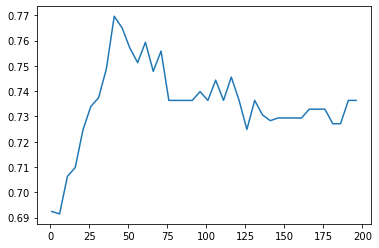

In [211]:
plt.plot(n_ests, aucs)
plt.show()

> **Вывод**: начиная с минимальных значений `n_estimators` результативность модели повышается ($AUC\_ROC \rightarrow max$). Однако после достижения некоторого максимума он перестаёт стабильно и очевидно зависеть от `n_estimators`.

**Задание 3.6 (0.5 балла)** Для лучшей модели случайного леса из **Задания 3.4** посчитайте важность признаков и постройте bar plot. Какой признак оказался самым важным для определения диабета?

In [11]:
rf = RandomForestClassifier(n_estimators=50, max_depth=15, min_samples_split=3, random_state=13)
rf.fit(X_train, y_train)

rf.feature_importances_

array([0.09322879, 0.25974141, 0.08518206, 0.06885269, 0.0712857 ,
       0.16300744, 0.11755736, 0.14114454])

In [14]:
fi_df = pd.DataFrame({
    "feature": X.columns,
    "importance": rf.feature_importances_
}).sort_values(by="importance", ascending=False).reset_index(drop=True)
fi_df

,feature,importance
0,Glucose,0.259741
1,BMI,0.163007
2,Age,0.141145
3,DiabetesPedigreeFunction,0.117557
4,Pregnancies,0.093229
5,BloodPressure,0.085182
6,Insulin,0.071286
7,SkinThickness,0.068853


C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


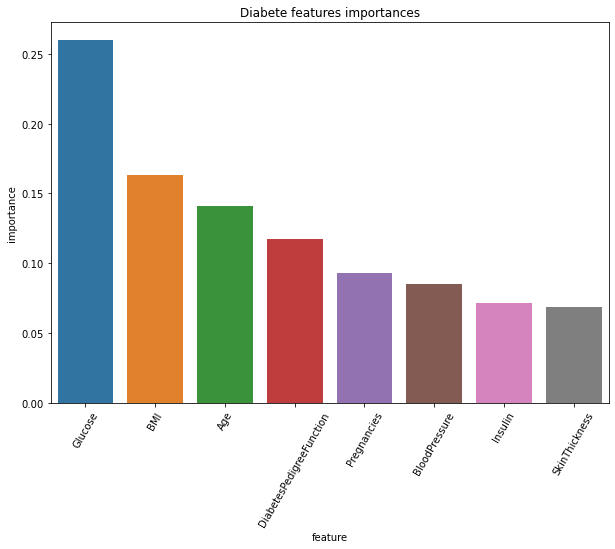

In [35]:
plt.figure(figsize=(10, 7))
sns.barplot(fi_df['feature'], fi_df['importance'])
plt.title('Diabete features importances')
plt.xticks(rotation=60)
plt.show()